## Dataset preparation

In [1]:
import os
from typing import Callable, Tuple
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms

In [2]:
class DIV2KDataset(Dataset):
    def __init__(self, root: str, modification: Callable | None = None):
        self.root = root
        self.image_paths = [
            os.path.join(root, f) for f in os.listdir(root) if f.endswith(".png")
        ]
        self.transform = transforms.ToTensor()
        self.modification = modification

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor]:
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        img = img.astype(np.float32) / 255.0

        img = self.transform(img)

        if self.modification:
            modified_img = self.modification(img)
        else:
            modified_img = img

        return modified_img, img


In [3]:
def add_random_mask(
    img: torch.Tensor,
    mask_size: tuple[int, int] = (64, 64),
    num_patches: int = 1
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Generate a random mask and apply it to the image.
    """
    _, h, w = img.shape
    mask = torch.ones((1, h, w), dtype=img.dtype, device=img.device)

    for _ in range(num_patches):
        # Randomly select the top-left corner of each mask
        x = np.random.randint(0, w - mask_size[0])
        y = np.random.randint(0, h - mask_size[1])

        # Set mask region to zero (black)
        mask[:, y:y+mask_size[1], x:x+mask_size[0]] = 0

    # Set mask region to zero (black)
    mask[:, y:y+mask_size[1], x:x+mask_size[0]] = 0

    # Apply mask to the image
    masked_img = img * mask

    return masked_img, mask

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%env DIV2K_DATA_PATH=/content/drive/MyDrive/data/DIV2K

env: DIV2K_DATA_PATH=/content/drive/MyDrive/data/DIV2K


In [41]:
from torch.utils.data import DataLoader

num_patches = 1
mask_size = (32, 32)

dataset = DIV2KDataset(
    root=f"{os.getenv('DIV2K_DATA_PATH')}/DIV2K_train_HR",
    modification=lambda img: add_random_mask(img, mask_size=mask_size, num_patches=num_patches),
)
train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

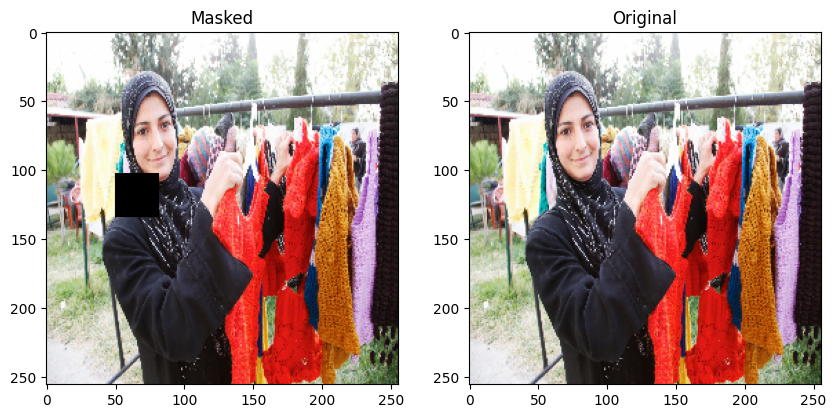

In [42]:
import matplotlib.pyplot as plt

x, y = next(iter(train_dataloader))
x_, mask = x
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(x_[0].permute(1, 2, 0))
axs[0].set_title("Masked")
axs[1].imshow(y[0].permute(1, 2, 0))
axs[1].set_title("Original")
plt.show()

In [43]:
eval_dataset = DIV2KDataset(
    root=f"{os.getenv('DIV2K_DATA_PATH')}/DIV2K_valid_HR",
    modification=lambda img: add_random_mask(img, mask_size=mask_size, num_patches=num_patches),
)
eval_dataloader = DataLoader(eval_dataset, batch_size=16, shuffle=True)

## Model definition

In [70]:
###############################################################################
# BSD 3-Clause License
#
# Copyright (c) 2018, NVIDIA CORPORATION. All rights reserved.
#
# Author & Contact: Guilin Liu (guilinl@nvidia.com)
###############################################################################

import torch
import torch.nn.functional as F
from torch import nn, cuda
from torch.autograd import Variable

class PartialConv2d(nn.Conv2d):
    def __init__(self, *args, **kwargs):

        # whether the mask is multi-channel or not
        if 'multi_channel' in kwargs:
            self.multi_channel = kwargs['multi_channel']
            kwargs.pop('multi_channel')
        else:
            self.multi_channel = False

        if 'return_mask' in kwargs:
            self.return_mask = kwargs['return_mask']
            kwargs.pop('return_mask')
        else:
            self.return_mask = False

        super(PartialConv2d, self).__init__(*args, **kwargs)

        if self.multi_channel:
            self.weight_maskUpdater = torch.ones(self.out_channels, self.in_channels, self.kernel_size[0], self.kernel_size[1])
        else:
            self.weight_maskUpdater = torch.ones(1, 1, self.kernel_size[0], self.kernel_size[1])

        self.slide_winsize = self.weight_maskUpdater.shape[1] * self.weight_maskUpdater.shape[2] * self.weight_maskUpdater.shape[3]

        self.last_size = (None, None, None, None)
        self.update_mask = None
        self.mask_ratio = None

    def forward(self, input, mask_in=None):
        assert len(input.shape) == 4
        if mask_in is not None or self.last_size != tuple(input.shape):
            self.last_size = tuple(input.shape)

            with torch.no_grad():
                if self.weight_maskUpdater.type() != input.type():
                    self.weight_maskUpdater = self.weight_maskUpdater.to(input)

                if mask_in is None:
                    # if mask is not provided, create a mask
                    if self.multi_channel:
                        mask = torch.ones(input.data.shape[0], input.data.shape[1], input.data.shape[2], input.data.shape[3]).to(input)
                    else:
                        mask = torch.ones(1, 1, input.data.shape[2], input.data.shape[3]).to(input)
                else:
                    mask = mask_in

                self.update_mask = F.conv2d(mask, self.weight_maskUpdater, bias=None, stride=self.stride, padding=self.padding, dilation=self.dilation, groups=1)

                # for mixed precision training, change 1e-8 to 1e-6
                self.mask_ratio = self.slide_winsize/(self.update_mask + 1e-8)
                # self.mask_ratio = torch.max(self.update_mask)/(self.update_mask + 1e-8)
                self.update_mask = torch.clamp(self.update_mask, 0, 1)
                self.mask_ratio = torch.mul(self.mask_ratio, self.update_mask)


        raw_out = super(PartialConv2d, self).forward(torch.mul(input, mask) if mask_in is not None else input)

        if self.bias is not None:
            bias_view = self.bias.view(1, self.out_channels, 1, 1)
            output = torch.mul(raw_out - bias_view, self.mask_ratio) + bias_view
            output = torch.mul(output, self.update_mask)
        else:
            output = torch.mul(raw_out, self.mask_ratio)


        if self.return_mask:
            return output, self.update_mask
        else:
            return output

In [71]:
class PartialConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(PartialConvBlock, self).__init__()
        self.conv = nn.Sequential(
            PartialConv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            PartialConv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)

In [72]:
class PartialDown(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(PartialDown, self).__init__()
        self.conv = PartialConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.conv(x)
        pooled = self.pool(features)
        return features, pooled


class PartialUp(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(PartialUp, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = PartialConvBlock(in_channels, out_channels)

    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:
        x = self.upconv(x)  # Upsample
        x = torch.cat((x, skip), dim=1)  # Concatenate with skip connection
        return self.conv(x)

In [73]:
class PartialConvInpaintingUNet(nn.Module):
    """U-Net model for image inpainting"""
    def __init__(self, in_channels: int = 4, out_channels: int = 3):
        super(PartialConvInpaintingUNet, self).__init__()

        self.down1 = PartialDown(in_channels, 64)
        self.down2 = PartialDown(64, 128)
        self.down3 = PartialDown(128, 256)
        self.down4 = PartialDown(256, 512)

        self.bottleneck = PartialConvBlock(512, 1024)

        self.up1 = PartialUp(1024, 512)
        self.up2 = PartialUp(512, 256)
        self.up3 = PartialUp(256, 128)
        self.up4 = PartialUp(128, 64)

        self.final_conv = PartialConv2d(64, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the U-Net.
        :param x: Masked image (B, 3, H, W)
        :param mask: Binary mask (B, 1, H, W) where 0 = missing pixels, 1 = valid pixels
        """
        # Concatenate the mask with the input image along the channel dimension
        x = torch.cat((x, mask), dim=1)

        # Encoder (Downsampling)
        skip1, d1 = self.down1(x)
        skip2, d2 = self.down2(d1)
        skip3, d3 = self.down3(d2)
        skip4, d4 = self.down4(d3)

        # Bottleneck
        bottleneck = self.bottleneck(d4)

        # Decoder (Upsampling with Skip Connections)
        up1 = self.up1(bottleneck, skip4)
        up2 = self.up2(up1, skip3)
        up3 = self.up3(up2, skip2)
        up4 = self.up4(up3, skip1)

        return self.final_conv(up4)

In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)


class Down(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(Down, self).__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.conv(x)
        pooled = self.pool(features)
        return features, pooled


class Up(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(Up, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:
        x = self.upconv(x)  # Upsample
        x = torch.cat((x, skip), dim=1)  # Concatenate with skip connection
        return self.conv(x)

In [11]:
class InpaintingUNet(nn.Module):
    """U-Net model for image inpainting"""
    def __init__(self, in_channels: int = 4, out_channels: int = 3):
        super(InpaintingUNet, self).__init__()

        self.down1 = Down(in_channels, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)

        self.bottleneck = ConvBlock(512, 1024)

        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the U-Net.
        :param x: Masked image (B, 3, H, W)
        :param mask: Binary mask (B, 1, H, W) where 0 = missing pixels, 1 = valid pixels
        """
        # Concatenate the mask with the input image along the channel dimension
        x = torch.cat((x, mask), dim=1)

        # Encoder (Downsampling)
        skip1, d1 = self.down1(x)
        skip2, d2 = self.down2(d1)
        skip3, d3 = self.down3(d2)
        skip4, d4 = self.down4(d3)

        # Bottleneck
        bottleneck = self.bottleneck(d4)

        # Decoder (Upsampling with Skip Connections)
        up1 = self.up1(bottleneck, skip4)
        up2 = self.up2(up1, skip3)
        up3 = self.up3(up2, skip2)
        up4 = self.up4(up3, skip1)

        return self.final_conv(up4)

In [12]:
import torch.nn.functional as F
from torchvision import models

class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT).features[:16]
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg.eval()

    def forward(self, denoised, gt):
        denoised_features = self.vgg(denoised)
        gt_features = self.vgg(gt)
        loss = F.mse_loss(denoised_features, gt_features)
        return loss

## Evaluation Setup

In [13]:
!pip install -q pytorch-msssim

In [14]:
import numpy as np
import torch
import torch.nn.functional as F
import pytorch_msssim

In [35]:
def psnr(img1: torch.Tensor, img2: torch.Tensor) -> float:
    """
    Computes the Peak Signal-to-Noise Ratio (PSNR) between two images.
    """
    mse = F.mse_loss(img1, img2)  # Compute Mean Squared Error
    if mse == 0:
        return float("inf")  # Perfect match
    max_pixel = 1.0  # Since images are normalized [0,1]
    return 20 * torch.log10(max_pixel / torch.sqrt(mse))

def evaluate_psnr(model: nn.Module, dataloader: DataLoader, device: str) -> float:
    """
    Evaluates the model on the test dataset using PSNR.
    """
    model.eval()
    total_psnr = 0
    num_batches = 0

    with torch.no_grad():
        for imgs_with_masks, clean_imgs in dataloader:
            masked_imgs, masks = imgs_with_masks
            masked_imgs, masks, clean_imgs = masked_imgs.to(device), masks.to(device), clean_imgs.to(device)

            inpainted_imgs = model(masked_imgs, masks)  # Generate predictions
            batch_psnr = psnr(inpainted_imgs, clean_imgs)  # Compute PSNR

            total_psnr += batch_psnr.item()
            num_batches += 1

    avg_psnr = total_psnr / num_batches
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    return avg_psnr

ssim_loss = pytorch_msssim.SSIM(data_range=1.0, size_average=True, channel=3)

def evaluate_ssim(model: nn.Module, dataloader: DataLoader, device: str) -> float:
    model.eval()
    total_ssim = 0
    num_batches = 0

    with torch.no_grad():
        for imgs_with_masks, clean_imgs in dataloader:
            masked_imgs, masks = imgs_with_masks
            masked_imgs, masks, clean_imgs = masked_imgs.to(device), masks.to(device), clean_imgs.to(device)

            inpainted_imgs = model(masked_imgs, masks)
            batch_ssim = ssim_loss(inpainted_imgs, clean_imgs)

            total_ssim += batch_ssim.item()
            num_batches += 1

    avg_ssim = total_ssim / num_batches
    print(f"Average SSIM: {avg_ssim:.4f}")
    return avg_ssim

In [16]:
!pip install -q lpips

In [17]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)

In [36]:
import lpips

lpips_metric = lpips.LPIPS(net='vgg').to(device)  # Load VGG-based LPIPS metric

def evaluate_lpips(model: nn.Module, dataloader: DataLoader, device: str) -> float:
    model.eval()
    total_lpips = 0
    num_batches = 0

    with torch.no_grad():
        for imgs_with_masks, clean_imgs in dataloader:
            masked_imgs, masks = imgs_with_masks
            masked_imgs, masks, clean_imgs = masked_imgs.to(device), masks.to(device), clean_imgs.to(device)

            inpainted_imgs = model(masked_imgs, masks)
            batch_lpips = lpips_metric(inpainted_imgs, clean_imgs).mean()

            total_lpips += batch_lpips.item()
            num_batches += 1

    avg_lpips = total_lpips / num_batches
    print(f"Average LPIPS: {avg_lpips:.4f}")
    return avg_lpips

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


In [19]:
import matplotlib.pyplot as plt

def visualize_inpainting(model: nn.Module, dataloader: DataLoader, device: str, num_images: int = 4):
    model.eval()

    with torch.no_grad():
        imgs_with_masks, clean_imgs = next(iter(dataloader))
        masked_imgs, masks = imgs_with_masks
        masked_imgs, masks, clean_imgs = masked_imgs.to(device), masks.to(device), clean_imgs.to(device)

        inpainted_imgs = model(masked_imgs, masks).cpu().permute(0, 2, 3, 1).numpy()

    masked_imgs = masked_imgs.cpu().permute(0, 2, 3, 1).numpy()
    clean_imgs = clean_imgs.cpu().permute(0, 2, 3, 1).numpy()

    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 3))

    for i in range(num_images):
        axes[i, 0].imshow(masked_imgs[i])
        axes[i, 0].set_title("Masked Input")

        axes[i, 1].imshow(inpainted_imgs[i])
        axes[i, 1].set_title("Inpainted Output")

        axes[i, 2].imshow(clean_imgs[i])
        axes[i, 2].set_title("Ground Truth")

        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

    return fig

## Experiment Tracking Setup

In [20]:
! pip install -q neptune

In [21]:
import neptune

In [ ]:
NEPTUNE_PROJECT_NAME = "sigk/image-inpainting"
NEPTUNE_API_KEY = input()

## Training

In [23]:
%env MODEL_CHECKPOINTS_PATH=/content/drive/MyDrive/studia/sigk/model_checkpoints

env: MODEL_CHECKPOINTS_PATH=/content/drive/MyDrive/studia/sigk/model_checkpoints


In [24]:
from datetime import datetime

In [25]:
checkpoints_path = os.getenv("MODEL_CHECKPOINTS_PATH")

In [26]:
from tqdm import tqdm
import torch.optim as optim

In [80]:
def train(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.MSELoss,
    optimizer: optim.Adam,
    device: str,
    epochs: int = 5,
    run: neptune.Run | None = None,
    amp: bool = True,
) -> nn.Module:
    model.train()

    if amp:
      scaler = torch.amp.GradScaler()  # Enables mixed precision training

    for epoch in range(epochs):
        epoch_loss = 0

        for imgs_with_masks, clean_imgs in tqdm(dataloader):
            masked_imgs, masks = imgs_with_masks
            masked_imgs, masks, clean_imgs = masked_imgs.to(device), masks.to(device), clean_imgs.to(device)

            optimizer.zero_grad()

            if amp:
                with torch.amp.autocast(device_type=device_type):  # Automatically uses float16
                    outputs = model(masked_imgs, masks)
                    loss = criterion(outputs, clean_imgs)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(masked_imgs, masks)
                loss = criterion(outputs, clean_imgs)

                loss.backward()
                optimizer.step()



            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
        if run:
          run["train/epoch/loss"].append(epoch_loss)

    return model

IndentationError: expected an indented block after 'else' statement on line 29 (<ipython-input-80-4578020ad4ff>, line 31)

In [74]:
model = PartialConvInpaintingUNet()
criterion = nn.MSELoss()
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
#compiled_model = torch.compile(model)
model = model.to(device)
epochs = 5

In [75]:
run = neptune.init_run(
    project=NEPTUNE_PROJECT_NAME,
    api_token=NEPTUNE_API_KEY,
)
params = {
    "model_name": model.__class__.__name__,
    "optimizer_name": optimizer.__class__.__name__,
    "loss_function": criterion.__class__.__name__,
    "learning_rate": lr,
    "epochs": epochs
}
run["parameters"] = params
run["dataset/num_patches"] = num_patches
run["dataset/mask_size"] = str(mask_size)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/sigk/image-inpainting/e/IMPAINT-31


In [76]:
start_time = datetime.now()
model = train(model, train_dataloader, criterion, optimizer, device, epochs=epochs, run=run, amp=False)
train_time = datetime.now() - start_time
print(f"Training time: {train_time}")
run["train/time"] = train_time.seconds

100%|██████████| 50/50 [02:08<00:00,  2.56s/it]


Epoch 1/5, Loss: 0.0421


100%|██████████| 50/50 [02:13<00:00,  2.67s/it]


Epoch 2/5, Loss: 0.0063


100%|██████████| 50/50 [01:59<00:00,  2.38s/it]


Epoch 3/5, Loss: 0.0049


100%|██████████| 50/50 [01:58<00:00,  2.36s/it]


Epoch 4/5, Loss: 0.0051


100%|██████████| 50/50 [01:58<00:00,  2.37s/it]

Epoch 5/5, Loss: 0.0039
Training time: 0:10:17.465543


In [77]:
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
os.makedirs(f"{checkpoints_path}/{model.__class__.__name__}/{timestamp}")
model_path = f"{checkpoints_path}/{model.__class__.__name__}/{timestamp}/model.pt"
torch.save(model, model_path)
run["model/saved_model"].upload(model_path)
run["model/params"] = sum(p.numel() for p in model.parameters())

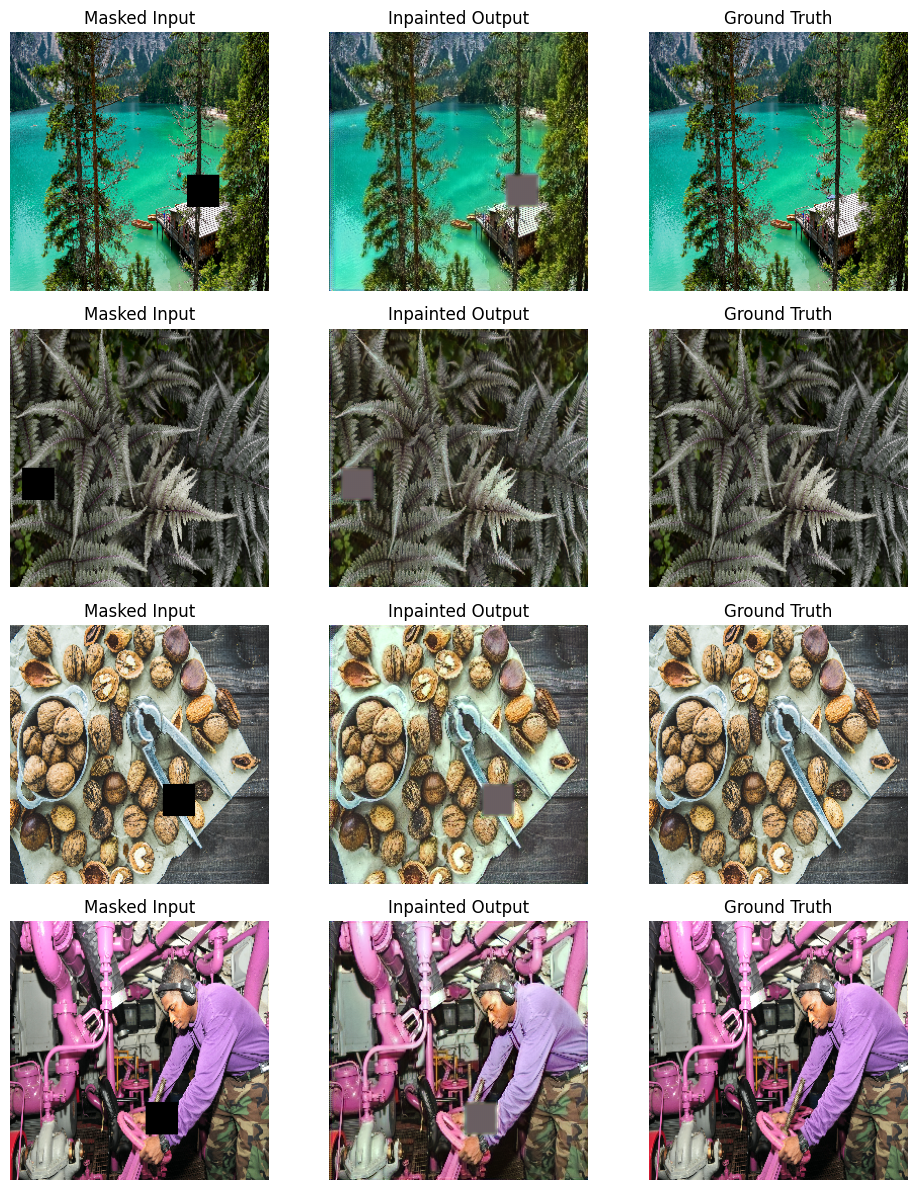

In [78]:
fig = visualize_inpainting(model, eval_dataloader, device)

In [79]:
run["eval/sample_preds"].upload(fig)

In [81]:
avg_psnr = evaluate_psnr(model, eval_dataloader, device)
avg_ssim = evaluate_ssim(model, eval_dataloader, device)
run["eval/psnr"] =  avg_psnr
run["eval/ssim"] = avg_ssim

Average PSNR: 24.98 dB
Average SSIM: 0.9270


In [82]:
avg_lpips = evaluate_lpips(model, eval_dataloader, device)
run["eval/lpips"] = avg_lpips

Average LPIPS: 0.0984


In [83]:
run["dataset/train"].track_files(f"{os.getenv('DIV2K_DATA_PATH')}/DIV2K_train_HR")
run["dataset/eval"].track_files(f"{os.getenv('DIV2K_DATA_PATH')}/DIV2K_valid_HR")

In [84]:
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/sigk/image-inpainting/e/IMPAINT-31/metadata


## Baseline

In [53]:
import torch
import torch.nn as nn
import numpy as np
import cv2

class OpenCVInpainting(nn.Module):
    def __init__(self, inpaint_radius=3):
        super(OpenCVInpainting, self).__init__()
        self.inpaint_radius = inpaint_radius

    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """
        Apply OpenCV's inpainting to a batch of images.
        :param x: Input tensor of shape (B, C, H, W) with masked regions.
        :param mask: Binary mask tensor of shape (B, 1, H, W), where 0 = missing areas, 1 = valid pixels.
        :return: Inpainted tensor of shape (B, C, H, W).
        """
        x_np = x.cpu().numpy()
        mask_np = mask.cpu().numpy()

        inpainted_images = np.zeros_like(x_np)

        for i in range(x_np.shape[0]):  # Process each image in batch separately
            for c in range(x_np.shape[1]):  # Process each color channel separately
                # Convert mask to OpenCV format (H, W) with values in {0, 255}
                opencv_mask = (1 - mask_np[i, 0]) * 255  # Invert mask: 0 → hole, 255 → valid

                inpainted_images[i, c] = cv2.inpaint(
                    x_np[i, c],  # Single channel of image
                    opencv_mask.astype(np.uint8),  # OpenCV mask (0 for valid, 255 for missing)
                    self.inpaint_radius,
                    cv2.INPAINT_TELEA  # Telea’s algorithm for inpainting
                )

        return torch.tensor(inpainted_images, dtype=torch.float32, device=x.device)  # Convert back to tensor


In [55]:
inpaint_radius = 10
model = OpenCVInpainting(inpaint_radius).to(device)

In [56]:
run = neptune.init_run(
    project=NEPTUNE_PROJECT_NAME,
    api_token=NEPTUNE_API_KEY,
    tags=["baseline"],
)
params = {
    "model_name": model.__class__.__name__,
    "inpaint_radius": inpaint_radius,
}
run["parameters"] = params
run["dataset/num_patches"] = num_patches
run["dataset/mask_size"] = str(mask_size)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/sigk/image-inpainting/e/IMPAINT-30


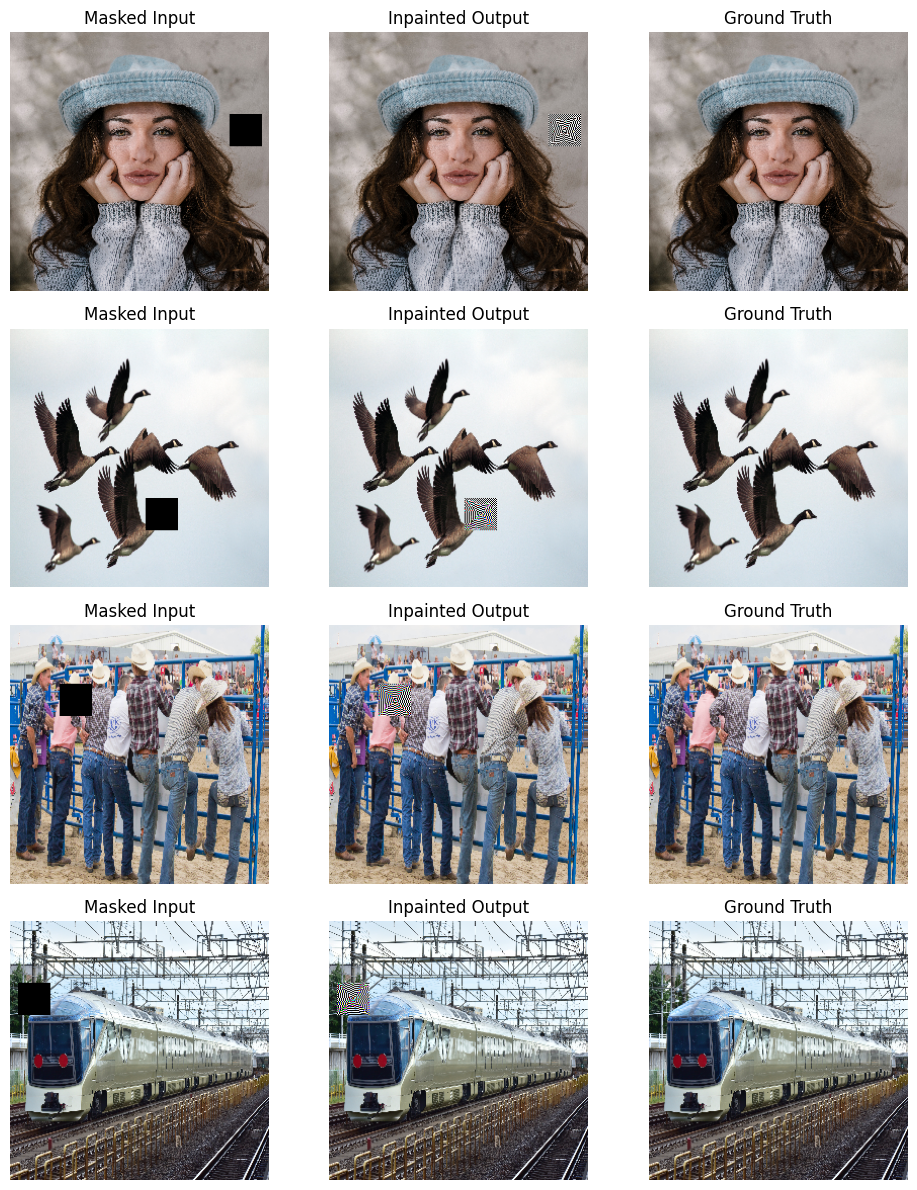

In [57]:
fig = visualize_inpainting(model, eval_dataloader, device)

In [58]:
run["eval/sample_preds"].upload(fig)

In [59]:
avg_psnr = evaluate_psnr(model, eval_dataloader, device)
avg_ssim = evaluate_ssim(model, eval_dataloader, device)
avg_lpips = evaluate_lpips(model, eval_dataloader, device)
run["eval/psnr"] =  avg_psnr
run["eval/ssim"] = avg_ssim
run["eval/lpips"] = avg_lpips

Average PSNR: 18.07 dB
Average SSIM: 0.9767
Average LPIPS: 0.0384
